In [6]:
import lettuce as lt
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import csv
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter

In [7]:
parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
parser.add_argument("--vtkdir", type=str, help="name base of vtk files - they are usually in a vtk-subdirectory!", default="./output/")
parser.add_argument("--csvdir", type=str, default="./output/")
parser.add_argument("--resolution", type=int, default=20)
parser.add_argument("--nout", type=int, default=100)
parser.add_argument("--nvtk", type=int, default=200)
parser.add_argument("--tmax", type=int, default=20)
parser.add_argument("--Re", type=int, default=400)
parser.add_argument("--collision_operator", type=str, default="BGK")
parser.add_argument("--Precision", type=str, default="Double")
parser.add_argument("--Mach", type=float, default=0.05)
args, unknown = parser.parse_known_args()
args = vars(args)
print("ICH FUNKTIONIERE MIT PULLEN")
Re=args["Re"]
basedir = args["vtkdir"]
csvdir = args["csvdir"]
res = args["resolution"]
nout = args["nout"]
nvtk = args["nvtk"]
tmax = args["tmax"]
Precision= args["Precision"]
collision_operator = args["collision_operator"]
Mach = args["Mach"]
print(collision_operator)
print(torch.version.cuda)

ICH FUNKTIONIERE MIT PULLEN
BGK
12.1


In [8]:
print(Precision)
lattice = lt.Lattice(lt.D3Q27, device = "cuda", dtype=torch.float32 if Precision == "Single" else torch.float64)
flow = lt.TaylorGreenVortex3D(resolution=res, reynolds_number=Re, mach_number=Mach, lattice=lattice)
print(flow.units.convert_time_to_lu(tmax))
tensor=torch.tensor(1)
print(tensor.dtype)
# Konstruktion des Funktionsnamens
function_name = f"{collision_operator}Collision"

# Überprüfung, ob die Funktion existiert, und deren Aufruf
#if hasattr(lt, function_name):
#    collision = getattr(lt, function_name)(lattice, tau=flow.units.relaxation_parameter_lu)
#    print(collision_operator)
#else:
#    print(":(((")
#    raise ValueError(f"Collision type {collision_operator} is not supported.")
if collision_operator == "BGK":
    collision=lt.BGKCollision(lattice, tau=flow.units.relaxation_parameter_lu)
elif collision_operator == "KBC":
    collision=lt.KBCCollision3D(lattice, tau=flow.units.relaxation_parameter_lu)
#collision = lt.BGKCollision(lattice, tau=flow.units.relaxation_parameter_lu)
#collision=collision_type(lattice, tau=flow.units.relaxation_parameter_lu)
print(flow.units.relaxation_parameter_lu)
print(flow.units.viscosity_pu)
streaming = lt.StandardStreaming(lattice)
simulation = lt.Simulation(flow=flow, lattice=lattice, collision=collision, streaming=streaming)


Double
2205.315581687168
torch.int64
0.5006891611192772
0.0025
torch.float64
torch.float64


In [9]:
interval_vtk=int((flow.units.convert_time_to_lu(tmax))/20)
interval_out=int((flow.units.convert_time_to_lu(tmax))/500)
Energy = lt.IncompressibleKineticEnergy(lattice, flow)
Dissipation_TGV=lt.Dissipation_sij(lattice, flow)
Enstrophy=lt.Enstrophy(lattice, flow)
Energyspectrum= lt.EnergySpectrum2(lattice, flow)
Symmetrie= lt.SymmetryReporter(lattice,flow)

reporter = lt.ObservableReporter(Energy, interval=interval_out, out=None)
reporter2 = lt.ObservableReporter(Dissipation_TGV,interval = interval_out, out=None)
reporter3= lt.ObservableReporter(Enstrophy, interval=interval_out, out=None)
#reporter4=lt.ObservableReporter(Energyspectrum, interval=interval_out, out=None)
reporter5 = lt.ObservableReporter(Symmetrie, interval=interval_out, out=None)
simulation.reporters.append(reporter)
simulation.reporters.append(reporter2)
simulation.reporters.append(reporter3)
#simulation.reporters.append(reporter4)
simulation.reporters.append(reporter5)
simulation.reporters.append(lt.VTKReporter(lattice, flow, interval=interval_vtk, filename_base=basedir+"out"))

steps = int(flow.units.convert_time_to_lu(tmax))
print(steps)

#simulation.reporters.append(lt.VTKReporter(lattice, flow, interval=interval_vtk, filename_base=basedir+"out"))

steps     time     IncompressibleKineticEnergy
steps     time     Dissipation_sij
steps     time     Enstrophy
2205


In [10]:
simulation.initialize_f_neq()
steps = int(flow.units.convert_time_to_lu(tmax))

mlups = simulation.step(num_steps=steps)
print("Performance in MLUPS:", mlups)
print(steps)
print(flow.units.relaxation_parameter_lu)

torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.

In [11]:
energy = np.array(simulation.reporters[0].out)
dissipation = np.array(simulation.reporters[1].out)
enstrophy=np.array(simulation.reporters[2].out)
#energy_spectrum= np.array(simulation.reporters[3].out)

sym = np.array(simulation.reporters[3].out) #ÄNDERN ZU 4 WEGEN ENERGIESPEKTRUM



dEdt=np.zeros(len(energy[:,2]))
dt=energy[1,1]-energy[0,1]
nmax=len(energy[:,2])
for i in range(len(energy[:,2])):
    if i == 0:
        dEdt[i] = (energy[1,2] - energy[0,2]) / dt
    elif i == 1:
        dEdt[i] = (energy[2,2] - energy[0,2]) / 2/dt
    elif i == 2:
        dEdt[i] = (1/12*energy[0,2] - 2/3*energy[1,2] + 2/3*energy[3,2] - 1/12*energy[4,2]) / dt
    elif i >= (nmax-3):
        if i == (nmax-3):
            dEdt[i] = (1/12*energy[nmax-5,2] - 2/3*energy[nmax-4,2] + 2/3*energy[nmax-2,2] - 1/12*energy[nmax-1,2]) / dt
        elif i == (nmax-2):
            dEdt[i] = (energy[nmax-1,2] - energy[nmax-3,2]) /2/ dt
        elif i == (nmax-1):
            dEdt[i] = (energy[nmax-1,2] - energy[nmax-2,2]) /dt
    elif i < (nmax-3):
        dEdt[i] = (-1/60*energy[i-3,2] + 3/20*energy[i-2,2] - 3/4*energy[i-1,2] + 3/4*energy[i+1,2] - 3/20*energy[i+2,2] + 1/60*energy[i+3,2]) / dt
dissipationEkin=np.array([energy[:,1],-dEdt/(np.pi*2)**3])
dissipationEns=np.array([enstrophy[:,1],flow.units.viscosity_pu/(np.pi*2)**3*enstrophy[:,2]])
dissipationSij=np.array([dissipation[:,1],dissipation[:,2]])

with open(csvdir + 'DissipationEkin.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipationEkin)
with open(csvdir + 'DissipationEnstrophy.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipationEns)
with open(csvdir + 'DissipationSij.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipationSij)
#with open(csvdir + 'EnergySpectrum.csv', 'w', newline='') as file:
#    writer = csv.writer(file)
#    writer.writerows(energy_spectrum)
with open(csvdir + 'Symmetrie.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(sym)


[31.00627668 30.95708671 30.9476708  30.93289027 30.88627265 30.90030442
 30.87153356 30.85446134 30.86158632 30.81483789 30.81163127 30.78617277
 30.74428906 30.75405322 30.7195365  30.70946225 30.70723093 30.6621255
 30.66281024 30.63102049 30.59357897 30.59462149 30.55656722 30.55242552
 30.54133908 30.49852542 30.49779115 30.46134561 30.43108971 30.42214304
 30.37912129 30.37778486 30.36052496 30.32134393 30.31506169 30.27350271
 30.2497563  30.23326602 30.18666884 30.18177489 30.15845496 30.12583203
 30.1127718  30.06507983 30.04430325 30.02157266 29.97514533 29.96370342
 29.93133938 29.90418075 29.88702995 29.83472316 29.81125785 29.78188174
 29.73864345 29.72041969 29.67872377 29.65284631 29.63109086 29.57898033
 29.55129509 29.51184853 29.47131258 29.44916422 29.4002665  29.37118096
 29.34327177 29.29390352 29.2629505  29.21417868 29.17307478 29.14624706
 29.09523823 29.06263957 29.02535992 28.97804739 28.94614775 28.89139141
 28.8472426  28.81364672 28.763132   28.7288593  28.

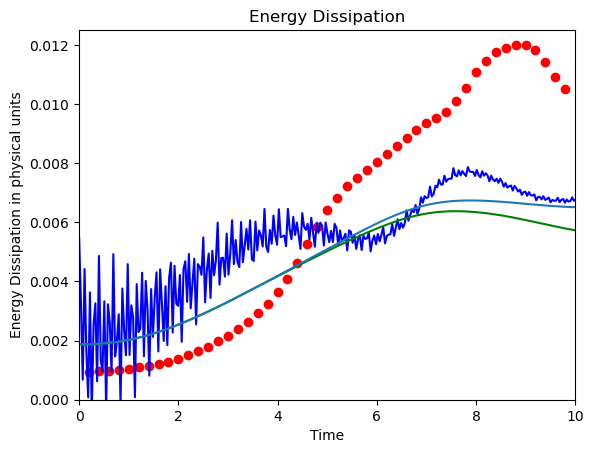

In [12]:
csv_file_path = '/home/ben/Schreibtisch/Enstropy Brachet/Brachet/Brachet_1983_tgv3d_enstrophy_Re800.csv'

# Daten aus der CSV-Datei lesen
csv_data = []
with open(csv_file_path, 'r') as file:
    csv_reader = csv.reader(file, delimiter=';')
    for row in csv_reader:
        csv_data.append(row)

csv_data = np.array(csv_data, dtype=float)
print(energy[:,2])
plt.plot(dissipationEkin[0,:],dissipationEkin[1,:],color = 'blue')
plt.plot(dissipationEns[0,:],dissipationEns[1,:], color = 'green')
plt.xlim(0,10)
plt.ylim(0,0.0125)
plt.plot(dissipationSij[0,:],dissipationSij[1,:])
plt.scatter(csv_data[:, 0], csv_data[:, 1], color='red', label='CSV Data')
plt.title('Energy Dissipation')
#plt.plot(energy[:,1],energy[:,2])
plt.xlabel('Time')
plt.ylabel('Energy Dissipation in physical units')
plt.show()

